In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics

spn 5246 spn-fmi 1569-31 faultid = recordid

In [2]:
faults = pd.read_csv('../data/J1939Faults.csv')
vehicleDiagnostic = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv')
faultCodes = pd.read_excel('../data/Service Fault Codes_1_0_0_167.xlsx')

C:\Users\hcgre\AppData\Local\Temp\ipykernel_9420\985816224.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  faults = pd.read_csv('../data/J1939Faults.csv')
C:\Users\hcgre\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


**Finding trucks that are within one mile of a service center** 

In [3]:
gdf = gpd.GeoDataFrame(faults, geometry=gpd.points_from_xy(faults.Longitude, faults.Latitude), crs="EPSG:4326")

In [4]:
points = pd.DataFrame({
    'lat' : [36.0666667, 35.5883333, 36.1950],
    'lon' : [-86.4347222, -86.4438888, -83.174722]
})

points = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.lon, points.lat), crs="EPSG:4326")

points['buffergeometry1mile'] = points['geometry'].buffer(0.01)

points.set_geometry('buffergeometry1mile',inplace=True)

C:\Users\hcgre\AppData\Local\Temp\ipykernel_9420\4116657202.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points['buffergeometry1mile'] = points['geometry'].buffer(0.01)


In [5]:
intersection = gpd.overlay(gdf, points, how='intersection', keep_geom_type=False)

lessThanMile = intersection['RecordID'].unique().tolist()

**Filtering out faults that occurred within one mile of the service center**

In [6]:
faults = faults.loc[~faults['RecordID'].isin(lessThanMile)].copy()

faults = faults.drop(columns = 'geometry')

**Filtering the equipment id to be less than 5 in length**

In [7]:
faults['EquipmentID'] = faults['EquipmentID'].astype(str)

faults = faults.loc[faults['EquipmentID'].str.len() < 5]

**Grabbing a list of trucks that have has either a 5246 or a 1569-31**

In [8]:
trucks5246 = faults.loc[faults['spn'] == 5246]['EquipmentID'].unique().tolist()

trucks1569 = faults.loc[(faults['spn'] == 1569) & (faults['fmi'] == 31)]['EquipmentID'].unique().tolist()

faults['EventTimeStamp'] = pd.to_datetime(faults['EventTimeStamp']) #turning EventTimeStamp into a datetime

**Looking at the faults that happen no more than a week before the full derate occurs**

In [9]:
df = []

for truck in range(0, len(trucks5246)):
    dates = (
        faults
        .loc[
            (faults['EquipmentID'] == trucks5246[truck]) & 
            (faults['spn'] == 5246) 
            #(faults['active'] == True)
        ]['EventTimeStamp']
        .tolist()
    )
    
    for i in range(0, len(dates)):
        date = dates[i] - datetime.timedelta(days=8)
        
        df.append(
            faults.loc[
                (faults['EquipmentID'] == trucks5246[truck]) & 
                (faults['EventTimeStamp'] <= dates[i]) & 
                (faults['EventTimeStamp'] >= date) 
                #(faults['active'] == True)
            ]
        )
        
weekOf5246 = pd.concat(df).drop_duplicates('RecordID')

**Clustering spn and fmi codes together based on their cumming description**

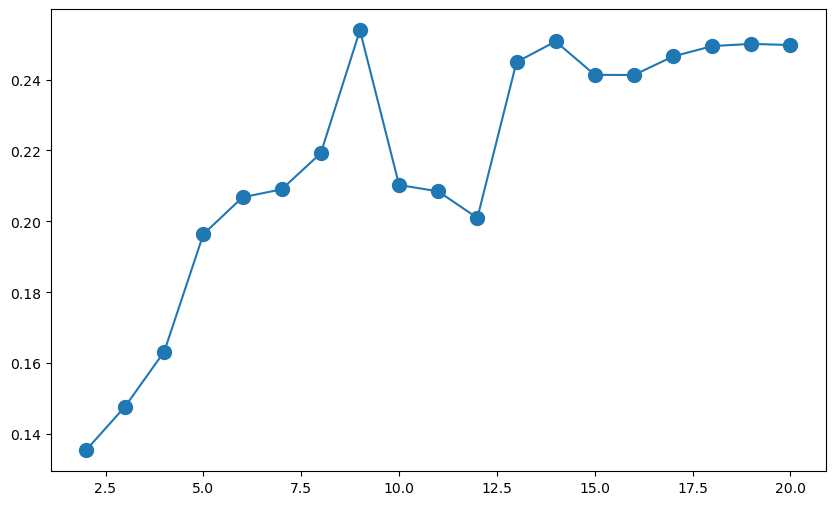

In [10]:
faultDesc = faultCodes[['SPN', 'J1939 FMI', 'Cummins Description']]

#using tfidfvectorizer to turn the description column into a vector
tf_idf_vect = TfidfVectorizer(lowercase=True,
                        stop_words = 'english')

faultDesc_vector = tf_idf_vect.fit_transform(faultDesc['Cummins Description'])

#checking silhouette score to find the best number of clusters
silhouette = []

max_clusters = 20
for k in range(2, max_clusters + 1):
    
    kmeans = KMeans(n_clusters = k, max_iter=200, n_init=10, random_state = 777)

    kmeans.fit(faultDesc_vector)
    
    silhouette.append(metrics.silhouette_score(faultDesc_vector, kmeans.labels_, metric='euclidean'))

#ploting silhouette score
plt.figure(figsize = (10,6))
plt.plot(range(2, max_clusters + 1), silhouette)
plt.scatter(range(2, max_clusters + 1), silhouette, s = 100);

In [11]:
kmeans = KMeans(n_clusters = 9, max_iter=200, n_init=10, random_state = 777)

kmeans.fit(faultDesc_vector)

KMeans(max_iter=200, n_clusters=9, n_init=10, random_state=777)

In [12]:
faultCodes['cluster'] = kmeans.labels_

faultCodes = faultCodes.rename(columns = {
    'SPN' : 'spn',
    'J1939 FMI' : 'fmi'
})

**Merging the count of faults prior to a derate with the count of faults when no derate occurs to see if there are any codes that could maybe be a indicator to a potential derate happening**

In [13]:
faultCompare = pd.merge(
    left = (
        weekOf5246.loc[weekOf5246['active'] == True][['RecordID', 'spn', 'fmi']]
        .groupby(['spn', 'fmi'])
        .count()
        .reset_index()
        .sort_values(by = 'RecordID', ascending = False)
        .rename(columns = {'RecordID' : 'count5246'})
    ),
    right = (
        faults.loc[(~faults['EquipmentID'].isin(trucks5246)) & faults['active'] == True][['RecordID', 'spn', 'fmi']]
        .groupby(['spn', 'fmi'])
        .count()
        .reset_index()
        .sort_values(by = 'RecordID', ascending = False)
        .rename(columns = {'RecordID' : 'countNo5246'})
    ),
    how = 'outer',
    on = ['spn', 'fmi']
).fillna(0).merge(
    right = faultCodes[['spn', 'fmi', 'cluster']],
    how = 'left',
    on = ['spn', 'fmi']
)

faultCompare['totals'] = faultCompare['count5246'] + faultCompare['countNo5246']

faultCompare['percent5246'] = faultCompare['count5246'] / faultCompare['totals']

faultCompare['percentNo5246'] = faultCompare['countNo5246'] / faultCompare['totals']

columns = ['spn', 'fmi', 'cluster', 'count5246', 'countNo5246', 'totals', 'percent5246', 'percentNo5246']

In [32]:
faultCompare.loc[(faultCompare['totals'] > 100) & (faultCompare['percent5246'] > .05)].sort_values(by = 'count5246', ascending = False)[columns]

,spn,fmi,cluster,count5246,countNo5246,totals,percent5246,percentNo5246
0,96,3,6.0,1470.0,25624.0,27094.0,0.054256,0.945744
4,1569,31,0.0,701.0,2956.0,3657.0,0.191687,0.808313
5,5246,0,2.0,327.0,0.0,327.0,1.000000,0.000000
7,3362,31,5.0,109.0,227.0,336.0,0.324405,0.675595
8,1761,19,5.0,99.0,330.0,429.0,0.230769,0.769231
9,1068,2,NaN,93.0,655.0,748.0,0.124332,0.875668
12,1761,9,5.0,83.0,281.0,364.0,0.228022,0.771978
14,3364,9,5.0,71.0,211.0,282.0,0.251773,0.748227
16,3216,4,6.0,63.0,464.0,527.0,0.119545,0.880455
17,3216,4,6.0,63.0,464.0,527.0,0.119545,0.880455


**Looking into what seasons derates tend to happen the most**

* winter - dec-feb
* spring - mar-may
* summer - june-aug
* fall - sep-nov

In [15]:
derateMonths = (
    faults
    .loc[(faults['spn'] == 5246) & (faults['active'] == True)][['RecordID', 'EventTimeStamp']]
)

derateMonths['month'] = pd.DatetimeIndex(derateMonths['EventTimeStamp']).month

In [16]:
derateMonths['season'] = np.where(
    ((derateMonths['month'] >= 1) & (derateMonths['month'] <= 2)) | (derateMonths['month'] == 12), 'winter',
np.where(
    (derateMonths['month'] >= 3) & (derateMonths['month'] <= 5), 'spring',
np.where(
    (derateMonths['month'] >= 6) & (derateMonths['month'] <= 8), 'summer', 'fall'
)))

In [17]:
derateMonths[['RecordID', 'season']].groupby(by = 'season').count().rename(columns = {'RecordID' : 'totalDerates'})

,totalDerates
season,
fall,110
spring,113
summer,104
winter,169
